# $k$-means vs GMM

The objective of this lab is to compare the performance of two clustering algorithms, $k$-means and the EM algorithm for the Gaussian Mixture Model (GMM), on both synthetic and real data.

You will find below Python code for loading data samples either from the Gaussian Mixture Model (GMM) or from the [iris dataset](https://fr.wikipedia.org/wiki/Iris_de_Fisher) and for clustering these data samples by $k$-means and EM on the GMM.

## To do

1. Compare the performance of $k$-means and Gaussian mixture. Test various parameters for the GMM, and different values of $k$.
2. Implement a version of Gaussian mixture where the covariance matrices are diagonal (and thus stored as *vectors*) and test its performance. We refer to this algorithm as GMD (Gaussian Mixture with Diagonal covariance matrices)
3. Test these three algorithms ($k$-means, GMM and GMD) on data of your choice.

## Import packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn import datasets, metrics

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Synthetic data

In [5]:
def gaussian_samples(mean = 0, std_dev = 1, nb_samples = 1):
    '''Gaussian samples
    
    Parameters
    ----------
    mean: float or array of floats, default: 0
        Mean            
    std_dev: float or array of floats, default: 1
        Standard deviation (covariance = SS^T)
    nb_samples: int
        Number of samples
        
    Returns
    -------
    samples: array of floats of shape (nb_samples,dim)
        Gaussian samples (std_dev * normal_samples + mean)
    '''
        
    mean = np.array(mean)
    std_dev = np.array(std_dev)
    try:
        dim = mean.shape[0]
    except:
        dim = 1
    normal_samples = np.random.normal(size = dim * nb_samples).reshape(dim,nb_samples)
    samples = np.array(std_dev).dot(normal_samples) 
    samples += np.array(mean).reshape(dim,1).dot(np.ones((1,nb_samples)))
    return samples.T

In [6]:
def gmm_samples(means = [0], std_devs = [1], p = None, nb_samples = 1):
    '''Gaussian mixture model samples
    
    Parameters
    ----------
    means: array of floats of shape (nb_modes,dim)
        Means            
    std_dev: array of floats of shape (nb_modes,dim,dim)
        Standard deviations
    p: array of floats of shape (nb_modes)
        Mixing distribution (sums to 1)
    nb_samples: int
        Number of samples
        
    Returns
    -------
    samples: array of floats of shape (nb_samples,dim)
        Gaussian mixture model samples 
    labels: array of integers of shape (nb_samples)
        labels (latent variables)
    '''
    means = np.array(means)
    std_devs = np.array(std_devs)
    nb_labels = means.shape[0]
    try:
        dim = means.shape[1]
    except:
        dim = 1
    labels = np.random.choice(nb_labels, size = nb_samples, p = p)
    samples = np.zeros((nb_samples,dim))
    for j in range(nb_labels):
        nb_samples_j = np.sum(labels == j)
        if nb_samples_j:
            index = np.where(labels == j)[0]
            samples[index] = gaussian_samples(means[j], std_devs[j], nb_samples_j)
    return samples, labels

In [7]:
def show_samples(samples, labels, features = [0,1], feature_names = None, display_labels = True):
    '''Display the samples in 2D'''
    if display_labels:
        nb_labels = np.max(labels)
        for j in range(nb_labels + 1):
            nb_samples = np.sum(labels == j)
            if nb_samples:
                index = np.where(labels == j)[0]
                plt.scatter(samples[index,features[0]],samples[index,features[1]])
    else:
        plt.scatter(samples[:,features[0]],samples[:,features[1]],color='gray')
    if feature_names is not None:
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
    plt.axis('equal')
    plt.show()

In [8]:
means = [[3,2],[-3,2],[0,-4]]
std_devs = [[[1,0],[0,1]],[[1,0],[0,1]],[[2,0],[0,2]]]
p = [0.25,0.25,0.5]

In [9]:
samples, labels = gmm_samples(means, std_devs, p, 300)

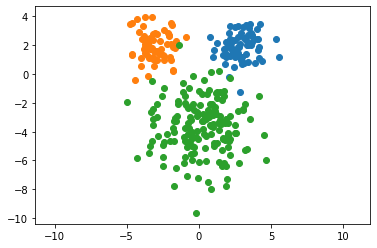

In [10]:
show_samples(samples, labels)

## Real data

In [11]:
iris = datasets.load_iris()
samples = iris.data  
feature_names = iris.feature_names
true_labels = iris.target
label_names = list(iris.target_names)

In [12]:
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [13]:
label_names

['setosa', 'versicolor', 'virginica']

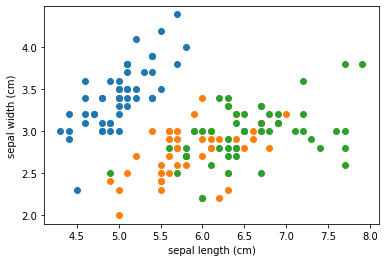

In [14]:
features = [0,1]
names = [feature_names[i] for i in features]
show_samples(samples, true_labels, features, names)

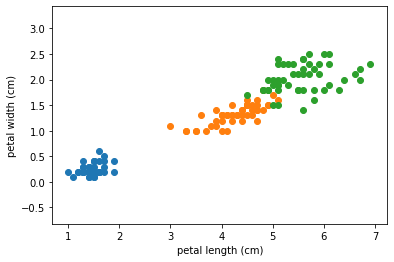

In [15]:
features = [2,3]
names = [feature_names[i] for i in features]
show_samples(samples, true_labels, features, names)

## Metrics

In [16]:
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_mutual_info_score as ami

## k-means

In [17]:
class KMeans:
    '''k-means algorithm
    
    Parameters
    ----------
    n_clusters: int, default: 8
        Number of clusters.
    
    n_init : int, default: 10
        Number of instances of k-means, each with different initial centers. 
        The output is that of the best instance (in terms of likelihood).
    
    n_iter: int, default: 300
        Number of iterations for each instance of k-means.
        
    algorithm: "random" or "++", default:"++"
        Algorithm for initializing the centers; "++" corresponds to k-means++.
    
    seed: int, default: None
        Seed for the random generation of initial centers.
        
    verbose: boolean, optional
        Verbose mode.
    
    Attributes
    ----------
    labels_: array, shape(n_samples,)
        Label of each sample (cluster index).
        
    centers_ : array, shape(n_clusters, n_features)
        Cluster centers.
        
    inertias_: array, shape(n_clusters,)
        Cluster inertias (sum of square distances).
    '''

    def __init__(self, n_clusters=8, n_init=10, n_iter=300, algorithm='++', seed=None, verbose = False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.n_iter = n_iter
        self.algorithm = algorithm
        self.seed = seed
        self.verbose = verbose
        self.labels_ = None
        self.centers_ = None
        self.inertias_ = None
       
    def fit(self, X):
        '''Cluster data X using k-means
    
        Parameters
        ----------
        X: array, shape(n_samples,n_features)
            Data to cluster.
        '''        
        
        def init_centers(self, X):
            if self.algorithm == 'random':
                # random centers 
                samples = np.random.choice(X.shape[0], size = self.n_clusters)
                centers = X[samples]
            else:
                # k-means++
                centers = []
                centers.append(X[np.random.randint(X.shape[0])])
                distance = np.full(X.shape[0], np.inf)
                for j in range(1,self.n_clusters):
                    distance = np.minimum(np.linalg.norm(X - centers[-1], axis=1), distance)
                    p = np.square(distance) / np.sum(np.square(distance))
                    sample = np.random.choice(X.shape[0], p = p)
                    centers.append(X[sample])
            return centers
        
        def compute_centers(self, X, labels):
            centers = []
            for j in range(self.n_clusters):
                index = np.where(labels == j)[0]
                if len(index):
                    centers.append(np.mean(X[index],axis = 0))
                else:
                    # reinit center in case of empty cluster
                    centers.append(X[np.random.choice(X.shape[0])])
            return np.array(centers)

        def compute_distances(self, X, centers):
            distances = []
            for j in range(self.n_clusters):
                distances.append(np.linalg.norm(X - centers[j], axis=1))
            return np.array(distances)
            
        def compute_inertias(self, X, labels, centers):
            inertias = []
            for j in range(self.n_clusters):
                index = np.where(labels == j)[0]
                inertias.append(np.sum(np.square(np.linalg.norm(X[index] - centers[j], axis=1))))
            return np.array(inertias)
    
        def one_kmeans(self, X):
            centers = init_centers(self, X)
            for i in range(self.n_iter):
                centers_old = centers.copy()
                distances = compute_distances(self, X, centers)
                labels = np.argmin(distances, axis=0)  
                centers = compute_centers(self, X, labels)
                if np.array_equal(centers, centers_old):
                    break
            inertias = compute_inertias(self, X, centers, labels)
            return labels, centers, inertias
            
        np.random.seed(self.seed)
        best_inertia = None
        # select the best instance of k-means
        for i in range(self.n_init):
            if self.verbose:
                print("Instance ",i)
            labels, centers, inertias = one_kmeans(self, X)
            inertia = np.sum(inertias)
            if best_inertia is None or inertia < best_inertia:
                best_labels = labels.copy()
                best_centers = centers.copy()
                best_inertias = inertias.copy()
                best_inertia = inertia

        self.labels_ = best_labels
        self.centers_ = best_centers
        self.inertias_ = best_inertias
        return self

In [18]:
km = KMeans(n_clusters = 3)

In [19]:
km.fit(samples)

## Gaussian mixture

In [20]:
class GMM:
    '''EM algorithm for the Gaussian mixture model
    
    Parameters
    ----------
    n_clusters: int, default: 8
        Number of clusters.
    
    n_init : int, default: 10
        Number of instances of the algorithm, each with different initial cluster centers. 
        The output is that of the best instance (in terms of likelihood).
    
    n_iter: int, default: 300
        Maximum number of iterations for each instance of the algorithm.
        
    algorithm: "random" or "k-means++", default:"k-means++"
        Algorithm for initializing the means.
    
    seed: int, default: None
        Seed for the random generation of cluster centers.
        
    verbose: boolean, default: True
        Verbose mode.
    
    Attributes
    ----------
    labels_: array, shape(n_samples,)
        Label of each sample (cluster index).

    label_probs_: array, shape(n_samples,n_clusters)
        Probability distribution of labels for each sample.
        
    centers_ : array, shape(n_clusters,n_features)
        Cluster centers.
    '''

    def __init__(self, n_clusters=8, n_init=10, n_iter=300, algorithm='k-means++', seed=None, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.n_iter = n_iter
        self.algorithm = algorithm
        self.seed = seed
        self.verbose = verbose
        self.labels_ = None
        self.label_probs_ = None
        self.centers_ = None
       
    def fit(self, X):
        '''Cluster data X using EM for the Gaussian mixture model
    
        Parameters
        ----------
        X: array, shape(n_samples,n_features)
            Data to cluster.
        '''        
        
        def init_parameters(self, X):
            # choose initial centers
            if self.algorithm == 'random':
                # random centers
                samples = np.random.choice(X.shape[0], size = self.n_clusters)
                centers = X[samples]
            else:
                # k-means++
                centers = []
                centers.append(X[np.random.randint(X.shape[0])])
                distance = np.full(X.shape[0], np.inf)
                for j in range(1,self.n_clusters):
                    distance = np.minimum(np.linalg.norm(X - centers[-1], axis=1), distance)
                    p = np.square(distance) / np.sum(np.square(distance))
                    sample = np.random.choice(X.shape[0], p = p)
                    centers.append(X[sample])
                
            # estimate the parameters from the induced clusters
            distances = []
            for j in range(self.n_clusters):
                distances.append(np.linalg.norm(X - centers[j], axis=1))
            labels = np.argmin(np.array(distances), axis=0)
            means = []
            covariances = []
            mixing_weights = []
            for j in range(self.n_clusters):
                index = np.where(labels == j)[0]
                mixing_weights.append(len(index))
                if len(index):
                    means.append(np.mean(X[index], axis = 0))
                    covariances.append(np.cov(X[index].T))    
                else:
                    means.append(centers[j])
                    covariances.append(np.eye(X.shape[1]))
            return np.array(means), np.array(covariances), np.array(mixing_weights)

        def compute_label_probs(self, X, means, covariances, mixing_weights):
            label_probs = np.zeros((X.shape[0],self.n_clusters))
            for j in range(self.n_clusters):
                cov = covariances[j]
                try:
                    inv_cov = np.linalg.inv(cov)
                    square_distances = ((X - means[j]).dot(inv_cov) * (X - means[j])).sum(axis = 1) 
                    label_probs[:,j] = np.exp(-square_distances / 2) / np.sqrt(np.linalg.det(cov))
                except:
                    if self.verbose:
                        print("Warning: Singular covariance matrix")
                    square_distances = np.square(X - means[j]).sum(axis = 1) 
                    label_probs[:,j] = np.exp(-square_distances / 2) 
            label_probs = label_probs * mixing_weights
            label_probs = (label_probs.T / label_probs.sum(axis = 1)).T
            return label_probs    
                        
        def compute_parameters(self, X, label_probs):
            mixing_weights = label_probs.sum(axis = 0)
            means = (X.T.dot(label_probs) / mixing_weights).T
            covariances = []
            for j in range(self.n_clusters):
                Y = (X - means[j]).T * label_probs[:,j]
                covariances.append(Y.dot(X - means[j]) / mixing_weights[j])
            return means, covariances, mixing_weights
        
        def compute_log_likelihood(self, X, means, covariances, mixing_weights):
            likelihoods = np.zeros((X.shape[0],self.n_clusters))
            total_weight = mixing_weights.sum()
            for j in range(self.n_clusters):
                cov = covariances[j]
                try:
                    inv_cov = np.linalg.inv(cov)
                    square_distances = ((X - means[j]).dot(inv_cov) * (X - means[j])).sum(axis = 1) 
                    likelihoods[:,j] = mixing_weights[j] / total_weight * np.exp(-square_distances / 2) / np.sqrt(np.linalg.det(cov))
                except:
                    if self.verbose:
                        print("Warning: Singular covariance matrix")
                    square_distances = np.square(X - means[j]).sum(axis = 1) 
                    likelihoods[:,j] = mixing_weights[j] / total_weight * np.exp(-square_distances / 2) 
            return np.log(likelihoods.sum(axis = 1)).sum()
    
        def single_run_EM(self, X):
            means, covariances, mixing_weights = init_parameters(self, X)
            labels = -np.ones(X.shape[0])
            for i in range(self.n_iter):    
                # Expectation
                label_probs = compute_label_probs(self, X, means, covariances, mixing_weights)              
                if np.array_equal(labels, label_probs.argmax(axis = 1)):
                    break
                else:
                # Maximization
                    means, covariances, mixing_weights = compute_parameters(self, X, label_probs)
                    labels = label_probs.argmax(axis = 1)
            return label_probs, means, covariances, mixing_weights
            
        np.random.seed(self.seed)
        best_loglikelihood = None
        # select the best instance of EM
        for i in range(self.n_init):
            if self.verbose:
                print("Instance ",i)               
            label_probs, means, covariances, mixing_weights = single_run_EM(self, X)
            loglikelihood = compute_log_likelihood(self, X, means, covariances, mixing_weights)
            if best_loglikelihood is None or loglikelihood > best_loglikelihood:
                best_loglikelihood = loglikelihood
                best_label_probs = label_probs
                best_labels = label_probs.argmax(axis = 1)
                best_centers = means
        self.label_probs_ = best_label_probs
        self.labels_ = best_labels
        self.centers_ = best_centers
        return self

In [21]:
gmm = GMM(n_clusters = 3)

In [22]:
gmm.fit(samples);

## Gaussian mixture with diagonal covariance matrices

In [121]:
class GMD:
    '''EM algorithm for the Gaussian mixture model with diagonal covariance matrices
    
    Parameters
    ----------
    n_clusters: int, default: 8
        Number of clusters.
    
    sigma_2: float, default: 0.1
        variance of the Gaussian distributions
    
    n_init : int, default: 10
        Number of instances of the algorithm, each with different initial cluster centers. 
        The output is that of the best instance (in terms of likelihood).
    
    n_iter: int, default: 300
        Maximum number of iterations for each instance of the algorithm.
        
    algorithm: "random" or "k-means++", default:"k-means++"
        Algorithm for initializing the means.
    
    seed: int, default: None
        Seed for the random generation of cluster centers.
        
    verbose: boolean, default: True
        Verbose mode.
    
    Attributes
    ----------
    labels_: array, shape(n_samples,)
        Label of each sample (cluster index).

    label_probs_: array, shape(n_samples,n_clusters)
        Probability distribution of labels for each sample.
        
    centers_ : array, shape(n_clusters,n_features)
        Cluster centers.
    '''

    def __init__(self, n_clusters=8, sigma_2=0.1, n_init=10, n_iter=300, algorithm='k-means++', seed=None, verbose=False):
        self.n_clusters = n_clusters
        self.sigma_2 = sigma_2
        self.n_init = n_init
        self.n_iter = n_iter
        self.algorithm = algorithm
        self.seed = seed
        self.verbose = verbose
        self.labels_ = None
        self.label_probs_ = None
        self.centers_ = None
        
        
    def fit(self, X):
        '''Cluster data X using EM for the Gaussian mixture model with diagonal covariance matrices
    
        Parameters
        ----------
        X: array, shape(n_samples,n_features)
            Data to cluster.
        '''                
        
        def init_parameters(self, X):
            # choose initial centers
            if self.algorithm == 'random':
                # random centers
                samples = np.random.choice(X.shape[0], size = self.n_clusters)
                centers = X[samples]
            else:
                # k-means++
                centers = []
                centers.append(X[np.random.randint(X.shape[0])])
                distance = np.full(X.shape[0], np.inf)
                for j in range(1,self.n_clusters):
                    distance = np.minimum(np.linalg.norm(X - centers[-1], axis=1), distance)
                    p = np.square(distance) / np.sum(np.square(distance))
                    sample = np.random.choice(X.shape[0], p = p)
                    centers.append(X[sample])
                
            # estimate the parameters from the induced clusters
            distances = []
            for j in range(self.n_clusters):
                distances.append(np.linalg.norm(X - centers[j], axis=1))
            labels = np.argmin(np.array(distances), axis=0)
            means = []
            covariances = []
            mixing_weights = []
            for j in range(self.n_clusters):
                index = np.where(labels == j)[0]
                # mixing_weights.append(len(index))
                mixing_weights.append(X.shape[0] / self.n_clusters)
                if len(index):
                    means.append(np.mean(X[index], axis = 0))
                    # covariances.append(np.cov(X[index].T))
                    covariances.append(self.sigma_2 * np.eye(X.shape[1]))
                else:
                    means.append(centers[j])
                    # covariances.append(np.eye(X.shape[1]))
                    covariances.append(self.sigma_2 * np.eye(X.shape[1]))
            return np.array(means), np.array(covariances), np.array(mixing_weights)

        def compute_label_probs(self, X, means, covariances, mixing_weights):
            label_probs = np.zeros((X.shape[0],self.n_clusters))
            for j in range(self.n_clusters):
                cov = covariances[j]
                try:
                    inv_cov = np.linalg.inv(cov)
                    square_distances = ((X - means[j]).dot(inv_cov) * (X - means[j])).sum(axis = 1) 
                    label_probs[:,j] = np.exp(-square_distances / 2) / np.sqrt(np.linalg.det(cov))
                except:
                    if self.verbose:
                        print("Warning: Singular covariance matrix")
                    square_distances = np.square(X - means[j]).sum(axis = 1) 
                    label_probs[:,j] = np.exp(-square_distances / 2) 
            label_probs = label_probs * mixing_weights
            label_probs = (label_probs.T / label_probs.sum(axis = 1)).T
            return label_probs    
                        
        def compute_parameters(self, X, label_probs):
            # mixing_weights = label_probs.sum(axis = 0)
            mixing_weights = X.shape[0] * np.ones(self.n_clusters) / self.n_clusters
            means = (X.T.dot(label_probs) / mixing_weights).T
            covariances = []
            for j in range(self.n_clusters):
                Y = (X - means[j]).T * label_probs[:,j]
                # covariances.append(Y.dot(X - means[j]) / mixing_weights[j])
                covariances.append(self.sigma_2 * np.eye(X.shape[1]))
            return means, covariances, mixing_weights
        
        def compute_log_likelihood(self, X, means, covariances, mixing_weights):
            likelihoods = np.zeros((X.shape[0],self.n_clusters))
            total_weight = mixing_weights.sum()
            for j in range(self.n_clusters):
                cov = covariances[j]
                try:
                    inv_cov = np.linalg.inv(cov)
                    square_distances = ((X - means[j]).dot(inv_cov) * (X - means[j])).sum(axis = 1) 
                    likelihoods[:,j] = mixing_weights[j] / total_weight * np.exp(-square_distances / 2) / np.sqrt(np.linalg.det(cov))
                except:
                    if self.verbose:
                        print("Warning: Singular covariance matrix")
                    square_distances = np.square(X - means[j]).sum(axis = 1) 
                    likelihoods[:,j] = mixing_weights[j] / total_weight * np.exp(-square_distances / 2) 
            return np.log(likelihoods.sum(axis = 1)).sum()
    
        def single_run_EM(self, X):
            means, covariances, mixing_weights = init_parameters(self, X)
            labels = -np.ones(X.shape[0])
            for i in range(self.n_iter):    
                # Expectation
                label_probs = compute_label_probs(self, X, means, covariances, mixing_weights)              
                if np.array_equal(labels, label_probs.argmax(axis = 1)):
                    break
                else:
                # Maximization
                    means, covariances, mixing_weights = compute_parameters(self, X, label_probs)
                    labels = label_probs.argmax(axis = 1)
            return label_probs, means, covariances, mixing_weights
            
        np.random.seed(self.seed)
        best_loglikelihood = None
        # select the best instance of EM
        for i in range(self.n_init):
            if self.verbose:
                print("Instance ",i)               
            label_probs, means, covariances, mixing_weights = single_run_EM(self, X)
            loglikelihood = compute_log_likelihood(self, X, means, covariances, mixing_weights)
            if best_loglikelihood is None or loglikelihood > best_loglikelihood:
                best_loglikelihood = loglikelihood
                best_label_probs = label_probs
                best_labels = label_probs.argmax(axis = 1)
                best_centers = means
        self.label_probs_ = best_label_probs
        self.labels_ = best_labels
        self.centers_ = best_centers
        return self
        


In [122]:
gmd = GMD(n_clusters = 3, sigma_2=0.1)

In [124]:
gmd.fit(samples);

## To do

1. Compare the performance of  𝑘 -means and Gaussian mixture. 

In [28]:
# use iris dataset
samples = iris.data  
feature_names = iris.feature_names
true_labels = iris.target
label_names = list(iris.target_names)

# test for k-mean performance with all features, 3 clusters
km = KMeans(n_clusters = 3)
km.fit(samples)
print("ARI with k-means is " + str(round(ari(km.labels_,true_labels),2)) + '.')


# test for Gaussian mixture performance with all features, 3 clusters
gmm = GMM(n_clusters = 3)
gmm.fit(samples)
print("ARI with Gaussian mixture is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

print('')
print("AMI with k-means is " + str(round(ami(km.labels_,true_labels),2)) + '.')
print("AMI with Gaussian mixture is " + str(round(ami(gmm.labels_,true_labels),2)) + '.')

ARI with k-means is 0.72.
ARI with Gaussian mixture is 0.9.

AMI with k-means is 0.73.
AMI with Gaussian mixture is 0.9.


The Gaussian mixture seems to provide better results. This is consistent whatever the evaluation criterion chosen, ARI or AMI. It thus seems that when all the information of the dataset is used, a Gaussian model is better capable of separating the different categories. What happens if only some of the features are used?

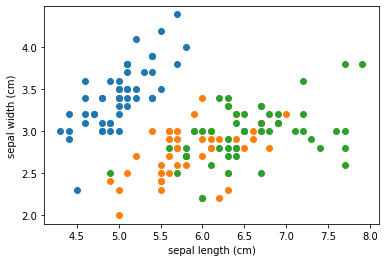

ARI with k-means is 0.6.
ARI with Gaussian mixture is 0.54.


In [30]:
# restrict the dataset to the first two features, as above
samples = iris.data[:,0:2]
features = [0,1]
names = [feature_names[i] for i in features]
show_samples(samples, true_labels, features, names)

# test for k-mean performance with all features, 3 clusters
km = KMeans(n_clusters = 3)
km.fit(samples)
print("ARI with k-means is " + str(round(ari(km.labels_,true_labels),2)) + '.')

# test for Gaussian mixture performance with all features, 3 clusters
gmm = GMM(n_clusters = 3)
gmm.fit(samples)
print("ARI with Gaussian mixture is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

Two remarks apply. First, the overall performance of the model has declined due to the loss of information resulting from the omission of two features. Second, the k-means model now performs better than the Gaussian mixture. This makes sense: as the graph above indicates, the green and orange categories are very mixed when using only the first two features. As a consequence, a Gaussian model will produce means that are very close for the two categories, which explains the many classification errors.

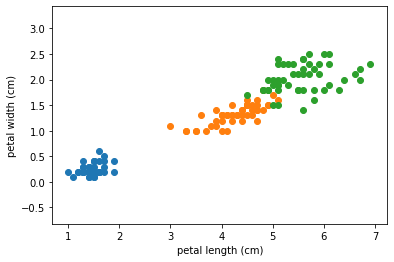

ARI with k-means is 0.85.
ARI with Gaussian mixture is 0.92.


In [31]:
# restrict the dataset to the last two features, as above
samples = iris.data
features = [2,3]
names = [feature_names[i] for i in features]
show_samples(samples, true_labels, features, names)
samples = iris.data[:,2:4]

# test for k-mean performance with all features, 3 clusters
km = KMeans(n_clusters = 3)
km.fit(samples)
print("ARI with k-means is " + str(round(ari(km.labels_,true_labels),2)) + '.')

# test for Gaussian mixture performance with all features, 3 clusters
gmm = GMM(n_clusters = 3)
gmm.fit(samples)
print("ARI with Gaussian mixture is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

The overall performance of the model is now quite good, and comparable to the model with all the features. This suggests that the two features petal length and petal width are the one that matters to separate correctly the different categories. Here also, the Gaussian model performs again better than the k-means approach. This is because, as shown on the above plot, the two features create well separated categories. Therefore, a Gaussian model centered around the mean proves quite efficient to identify the different categories.

2. Test various parameters for the GMM, and different values of  𝑘.

In [32]:
# work again with full iris dataset, and default setting
samples = iris.data  
feature_names = iris.feature_names
true_labels = iris.target
label_names = list(iris.target_names)
gmm = GMM(n_clusters = 3)
gmm.fit(samples)
print("ARI with default setting is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

ARI with default setting is 0.89.


In [33]:
# try with fewer clusters (only 2) and more clusters (extend to 5)
gmm = GMM(n_clusters = 2)
gmm.fit(samples)
print("ARI with 2 clusters is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')
gmm = GMM(n_clusters = 5)
gmm.fit(samples)
print("ARI with 5 clusters is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

ARI with 2 clusters is 0.57.
ARI with 5 clusters is 0.69.


It can be seen that not choosing the right number of clusters, be it more clusters or fewer clusters, results in a lower ARI score.

In [34]:
# try with fewer instances (only 2) and more instances (extend to 50)
gmm = GMM(n_clusters = 3, n_init=2)
gmm.fit(samples)
print("ARI with 5 instances is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')
gmm = GMM(n_clusters = 3, n_init=50)
gmm.fit(samples)
print("ARI with 50 instances is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

ARI with 5 instances is 0.87.
ARI with 50 instances is 0.92.


With significantly more instances, the algorithm performs usually better, which intuitively makes sense since the model is just given more chances to achieve a good performance.

In [35]:
# try with fewer iterations (only 20) and more iterations (extend to 5000)
gmm = GMM(n_clusters = 3, n_iter=20)
gmm.fit(samples)
print("ARI with 20 iterations is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')
gmm = GMM(n_clusters = 3, n_iter=5000)
gmm.fit(samples)
print("ARI with 5000 iterations is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

ARI with 20 iterations is 0.89.
ARI with 5000 iterations is 0.89.


It seems that changing the number of iterations only has a very marginal impact on performance.

In [36]:
# finally, test with random and k-means++ as initialisation algorithms
gmm = GMM(n_clusters = 3, algorithm='k-means++')
gmm.fit(samples)
print("ARI with k-means++ is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')
gmm = GMM(n_clusters = 3, algorithm='random')
gmm.fit(samples)
print("ARI with random is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

ARI with k-means++ is 0.9.
ARI with random is 0.9.


With the other base parameters, there is no clear effect of the initilisation algorithm on performance.

3. Implement a version of Gaussian mixture where the covariance matrices are diagonal (and thus stored as vectors) and test its performance. We refer to this algorithm as GMD (Gaussian Mixture with Diagonal covariance matrices)

I do this in the simplest way. I just amend the methods in the GMM class so that they now implement diagonal covariances matrices and fixed weights. Note that the weights MUST NOT be normalised (unlike what is showed in the slides), or the code will crash.

4. Test these three algorithms ( 𝑘-means, GMM and GMD) on data of your choice.

I test again the three algorithms on the full iris dataset:

In [125]:
# use iris dataset
samples = iris.data  
feature_names = iris.feature_names
true_labels = iris.target
label_names = list(iris.target_names)

# test for k-mean performance with all features, 3 clusters
km = KMeans(n_clusters = 3)
km.fit(samples)
print("ARI with k-means is " + str(round(ari(km.labels_,true_labels),2)) + '.')

# test for Gaussian mixture performance with all features, 3 clusters
gmm = GMM(n_clusters = 3)
gmm.fit(samples)
print("ARI with Gaussian mixture is " + str(round(ari(gmm.labels_,true_labels),2)) + '.')

# test for Gaussian mixture diagonal performance with all features, 3 clusters
gmd = GMD(n_clusters = 3)
gmd.fit(samples)
print("ARI with Gaussian mixture (diagonal) is " + str(round(ari(gmd.labels_,true_labels),2)) + '.')

print('')
print("AMI with k-means is " + str(round(ami(km.labels_,true_labels),2)) + '.')
print("AMI with Gaussian mixture is " + str(round(ami(gmm.labels_,true_labels),2)) + '.')
print("AMI with Gaussian mixture (diagonal) is " + str(round(ami(gmd.labels_,true_labels),2)) + '.')

ARI with k-means is 0.73.
ARI with Gaussian mixture is 0.92.
ARI with Gaussian mixture (diagonal) is 0.85.

AMI with k-means is 0.75.
AMI with Gaussian mixture is 0.91.
AMI with Gaussian mixture (diagonal) is 0.83.


Not surprisingly, the performance with the diagonal version is lower than with the full Gaussian mixture model. This is because the diagonal model is a simplified version of the Gaussian mixture model and thus offers less flexibility, resulting in lower classification capacities. The performance remains higher than the basic k-means, though.

In [143]:
# I finaly consider the impact of the value of sigma

# I finaly consider the impact of the value of sigma
# sigma_2 = 0.1
gmd = GMD(n_clusters = 3, sigma_2 = 0.1)
gmd.fit(samples)
print("ARI with sigma_2 = 0.001 is " + str(round(ari(gmd.labels_,true_labels),2)) + '.')

# I finaly consider the impact of the value of sigma
# sigma_2 = 1
gmd = GMD(n_clusters = 3, sigma_2 = 1)
gmd.fit(samples)
print("ARI with sigma_2 = 1 is " + str(round(ari(gmd.labels_,true_labels),2)) + '.')

# I finaly consider the impact of the value of sigma
# sigma_2 = 5
gmd = GMD(n_clusters = 3, sigma_2 = 5)
gmd.fit(samples)
print("ARI with sigma_2 = 5 is " + str(round(ari(gmd.labels_,true_labels),2)) + '.')
print('')
print('The centers produced with sigma_5=5 are: ')
print(gmd.centers_)

ARI with sigma_2 = 0.001 is 0.85.
ARI with sigma_2 = 1 is 0.7.
ARI with sigma_2 = 5 is 0.5.

The centers produced with sigma_5=5 are: 
[[5.83038344 3.06221323 3.72295143 1.18448897]
 [5.91507117 3.03910959 3.93149133 1.27204949]
 [5.78454538 3.07067718 3.61955724 1.14146154]]


Clearly, the value of sigma_2 has a string impact on the performance of the model. It seems that the value has to be chosen t be sufficiently small to avoir too loose distributions which tend to produce centers very close one from each other.